In [129]:
import numpy as np
import matplotlib.pyplot as plt 

def load_dataset(path):
    """Load the data in file to ndarrays of x matrix and array of y labels.
    
    Args:
        path: path to the text file containing data.
    Returns:
        dataset: ndarray of x matrix. Shape (m, n)
        labels: array of labels. Shape (m,)
    """
    with open(path, 'r') as fr:
        first_row = fr.readline().strip().split('\t')
    x_cols = [i for i in range(len(first_row) - 1)]
    l_col = [len(first_row) - 1]

    dataset = np.loadtxt(path, dtype=float, delimiter='\t', usecols=x_cols)
    labels = np.loadtxt(path, dtype=float, delimiter='\t', usecols=l_col)
    return dataset, labels

def select_random_j(i, m):
    """Select a random j in m numbers with j not equal to m.
    
    Args:
        i: index of alpha i
        m: number of examples
    Returns:
        j: integer that's not i    
    """
    j = i
    while (j == i):
        j = int(np.random.uniform(0, m))
    return j

def clip_alpha(alpha_j, L, H):
    """Clip alpha to make it lie in the [L, H] interval.
    
    Args:
        alpha_j: jth alpha to be clipped
        L: the low boundary of the interval
        H: the high boundary of the interval
    Returns:
        alpha_j: the clipped alpha_j
    """
    if alpha_j > H:
        alpha_j = H
    elif alpha_j < L:
        alpha_j = L
    else:
        alpha_j = alpha_j
    return alpha_j

def smo_simplified(dataset, labels, C, tolerance, max_iter):
    """Use simplified SMO algorithm to solve for SVM.
    
    Args:
        dataset: ndarray of x matrix. Shape (m, n)
        labels: array of labels. Shape (m,)
        C: the violation parameter
        tolerance: 
        max_iter: maximum iteration allowed for SMO
    Returns:
        alpha: array of alpha parameters
        b: intercept parameter. Integer
    """
    m, n = dataset.shape
    alpha = np.zeros(m)
    b = 0
    iteration = 0

    while (iteration < max_iter):
        alpha_pair_changed = 0  # flag for a pair of alphas changed

        for i in range(m):
            f_i = (alpha * labels).dot(dataset.dot(dataset[i])) + b
            err_i = f_i - labels[i]

            # check if it fulfills the KKT conditions
            if (labels[i] * err_i < -tolerance and alpha[i] < C) or (labels[i] * err_i > tolerance and alpha[i] > 0):
                j = select_random_j(i, m)
                f_j = (alpha * labels).dot(dataset.dot(dataset[j])) + b
                err_j = f_j - labels[j]

                alpha_i_pre = np.copy(alpha[i])
                alpha_j_pre = np.copy(alpha[j])

                # choose the low and high boundary for alpha i & j
                if labels[i] == labels[j]:
                    L = max(0, alpha[j] + alpha[i] - C)
                    H = min(C, alpha[j] + alpha[i])
                else:
                    L = max(0, alpha[j] - alpha[i])
                    H = min(C, C + alpha[j] - alpha[i])
                
                # calculate eta and update alpha j
                eta = 2.0 * dataset[i].dot(dataset[j]) - dataset[i].dot(dataset[i]) - dataset[j].dot(dataset[j])
                if eta >= 0:
                    print('eta >= 0')
                    continue
                
                alpha[j] -= labels[j] * (err_i - err_j) / eta
                alpha[j] = clip_alpha(alpha[j], L, H)
                if abs(alpha[j] - alpha_j_pre < 1e-5):
                    print("alpha j not moving enough")
                    continue

                # update alpha i
                alpha[i] += labels[i] * labels[j] * (alpha_j_pre - alpha[j])    # update alpha i by the same amount as j

                # update b
                b1 = b - err_i - labels[i] * (alpha[i] - alpha_i_pre) * dataset[i].dot(dataset[i]) \
                               - labels[j] * (alpha[j] - alpha_j_pre) * dataset[j].dot(dataset[i])
                b2 = b - err_j - labels[i] * (alpha[i] - alpha_i_pre) * dataset[i].dot(dataset[j]) \
                               - labels[j] * (alpha[j] - alpha_j_pre) * dataset[j].dot(dataset[j])
                if 0 < alpha[i] and alpha[i] < C:
                    b = b1
                elif 0 < alpha[j] and alpha[j] < C:
                    b = b2
                else:
                    b = (b1 + b2) / 2

                # change flag
                alpha_pair_changed += 1
                print("Iteration: {0} i: {1}, pairs changed: {2}".format(iteration, i, alpha_pair_changed))

        if alpha_pair_changed == 0:  # if alpha pairs stays unchanged for max_iter, 
            iteration += 1           # then alphas are solved and can quit loop
        else:
            iteration = 0
        print('itration number: {}'.format(iteration))
    
    return alpha, b

In [107]:
dataset, labels = load_dataset('testSet.txt')

In [178]:
alpha, b = smo_simplified(dataset, labels, 0.6, 0.001, 200)

alpha j not moving enough
Iteration: 0 i: 1, pairs changed: 1
alpha j not moving enough
alpha j not moving enough
Iteration: 0 i: 5, pairs changed: 2
alpha j not moving enough
Iteration: 0 i: 8, pairs changed: 3
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
Iteration: 0 i: 45, pairs changed: 4
alpha j not moving enough
Iteration: 0 i: 47, pairs changed: 5
alpha j not moving enough
Iteration: 0 i: 52, pairs changed: 6
alpha j not moving enough
Iteration: 0 i: 55, pairs changed: 7
alpha j not moving enough
alpha j not moving enough
Iteration: 0 i: 92, pairs changed: 8
alpha j not moving enough
itration number: 0
Iteration: 0 i: 1, pairs changed: 1
alpha j not moving enough
alpha j not moving enough
al

alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration number: 1
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration number: 2
Iteration: 2 i: 10, pairs changed: 1
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration number: 0
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration number: 1
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alp

alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration number: 2
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration number: 3
Iteration: 3 i: 17, pairs changed: 1
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration number: 0
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration number: 1
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration number: 2
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration number: 3
alpha j not movin

itration number: 13
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration number: 14
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration number: 15
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration number: 16
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration number: 17
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration number: 18
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration number: 19
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration number: 20
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration

alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration number: 56
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving

itration number: 0
alpha j not moving enough
alpha j not moving enough
itration number: 1
alpha j not moving enough
alpha j not moving enough
itration number: 2
alpha j not moving enough
alpha j not moving enough
itration number: 3
alpha j not moving enough
alpha j not moving enough
itration number: 4
alpha j not moving enough
alpha j not moving enough
itration number: 5
alpha j not moving enough
alpha j not moving enough
itration number: 6
alpha j not moving enough
alpha j not moving enough
itration number: 7
Iteration: 7 i: 17, pairs changed: 1
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration number: 0
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration number: 1
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration number: 2
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration number: 3
alpha j not moving enough
alpha j not moving enough
alpha j

itration number: 1
alpha j not moving enough
alpha j not moving enough
itration number: 2
alpha j not moving enough
alpha j not moving enough
itration number: 3
alpha j not moving enough
alpha j not moving enough
itration number: 4
alpha j not moving enough
alpha j not moving enough
itration number: 5
alpha j not moving enough
alpha j not moving enough
itration number: 6
alpha j not moving enough
alpha j not moving enough
itration number: 7
alpha j not moving enough
alpha j not moving enough
itration number: 8
alpha j not moving enough
alpha j not moving enough
itration number: 9
alpha j not moving enough
alpha j not moving enough
itration number: 10
alpha j not moving enough
alpha j not moving enough
itration number: 11
alpha j not moving enough
alpha j not moving enough
itration number: 12
alpha j not moving enough
alpha j not moving enough
itration number: 13
alpha j not moving enough
alpha j not moving enough
itration number: 14
alpha j not moving enough
alpha j not moving enough
i

alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration number: 1
alpha j not moving enough
alpha j not moving enough
Iteration: 1 i: 52, pairs changed: 1
alpha j not moving enough
alpha j not moving enough
itration number: 0
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration number: 1
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration number: 2
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration number: 3
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration number: 4
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration number: 5
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration number: 6
alpha

itration number: 9
alpha j not moving enough
itration number: 10
alpha j not moving enough
itration number: 11
alpha j not moving enough
itration number: 12
alpha j not moving enough
itration number: 13
alpha j not moving enough
itration number: 14
alpha j not moving enough
itration number: 15
alpha j not moving enough
itration number: 16
alpha j not moving enough
itration number: 17
alpha j not moving enough
itration number: 18
alpha j not moving enough
itration number: 19
alpha j not moving enough
itration number: 20
alpha j not moving enough
itration number: 21
alpha j not moving enough
itration number: 22
alpha j not moving enough
itration number: 23
alpha j not moving enough
itration number: 24
alpha j not moving enough
itration number: 25
alpha j not moving enough
itration number: 26
alpha j not moving enough
itration number: 27
alpha j not moving enough
itration number: 28
alpha j not moving enough
itration number: 29
alpha j not moving enough
alpha j not moving enough
alpha j n

itration number: 52
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration number: 53
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
Iteration: 53 i: 55, pairs changed: 1
itration number: 0
alpha j not moving enough
itration number: 1
alpha j not moving enough
itration number: 2
alpha j not moving enough
itration number: 3
alpha j not moving enough
itration number: 4
alpha j not moving enough
itration number: 5
alpha j not moving enough
itration number: 6
alpha j not moving enough
itration number: 7
alpha j not moving enough
itration number: 8
alpha j not moving enough
itration number: 9
alpha j not moving enough
itration number: 10
alpha j not moving enough
itration number: 11
alpha j not moving enough
itration number: 12
alpha j not moving enough
itration number: 13
alpha j not moving enough
itration number: 14
alpha j not moving enough
itration

alpha j not moving enough
alpha j not moving enough
itration number: 46
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration number: 47
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration number: 48
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration number: 49
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration number: 50
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration number: 51
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration number: 52
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration number: 53
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration number: 54
alpha j not moving enough
Iteration: 54 i: 29, pairs changed: 1
alpha j not moving enough
itration number: 0
alpha j not moving enough
itration 

alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration number: 161
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration number: 162
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration number: 163
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration number: 164
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration number: 165
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
alpha j not moving enough
itration number: 166
alpha j not moving enough
Iteration: 166 i: 29, pairs changed: 1
itration number: 0
alpha j not moving enough
itration number: 1
alpha j not moving enough
itration number: 2
alpha j not moving enough
itration number: 3
alpha j not moving enough
itrat

alpha j not moving enough
itration number: 10
alpha j not moving enough
itration number: 11
alpha j not moving enough
itration number: 12
alpha j not moving enough
itration number: 13
alpha j not moving enough
itration number: 14
alpha j not moving enough
itration number: 15
alpha j not moving enough
itration number: 16
alpha j not moving enough
itration number: 17
alpha j not moving enough
itration number: 18
alpha j not moving enough
itration number: 19
alpha j not moving enough
itration number: 20
alpha j not moving enough
itration number: 21
alpha j not moving enough
itration number: 22
alpha j not moving enough
itration number: 23
alpha j not moving enough
itration number: 24
alpha j not moving enough
itration number: 25
alpha j not moving enough
itration number: 26
alpha j not moving enough
itration number: 27
alpha j not moving enough
itration number: 28
alpha j not moving enough
itration number: 29
alpha j not moving enough
itration number: 30
alpha j not moving enough
itration

In [151]:
alpha[alpha > 0]

array([0.03794986, 0.02347231, 0.0950113 , 0.09874154, 0.16528914])

C:\Users\ziman\anaconda3\lib\site-packages\ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  del sys.path[0]


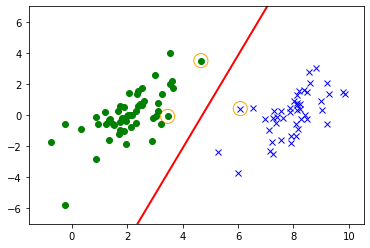

In [179]:
w = dataset.T.dot(alpha*labels)
sup_vec = dataset[alpha > 0, :]

fig, ax = plt.subplots()
ax.plot(dataset[labels==1, 0], dataset[labels==1, 1], "bx")
ax.plot(dataset[labels==-1, 0], dataset[labels==-1, 1], 'go')
x1 = np.arange(-1, 10, 0.01)
x2 = -(b + w[0] * x1) / w[1]
ax.plot(x1, x2, c = 'red', linewidth=2)
ax.set_ylim(-7, 7)

for i in range(sup_vec.shape[0]):
    ax.scatter(sup_vec[i, 0], sup_vec[i, 1], color='', marker='o', edgecolors='orange', s=200)